In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./kaggle/input\sample_submission.csv
./kaggle/input\test.csv
./kaggle/input\train.csv


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import BertPreTrainedModel, BertModel
from transformers import AutoConfig, AutoTokenizer

from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange

C:\Users\dong\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# plt.style.use('dark_background')

## Load Data

In [7]:
dftrain = pd.read_csv('./kaggle/input/train.csv')
dftest = pd.read_csv('./kaggle/input/test.csv')
sample_submission = pd.read_csv('./kaggle/input/sample_submission.csv')
print(dftrain,dftest,sample_submission)

             id                                          url_legal  \
0     c12129c31                                                NaN   
1     85aa80a4c                                                NaN   
2     b69ac6792                                                NaN   
3     dd1000b26                                                NaN   
4     37c1b32fb                                                NaN   
...         ...                                                ...   
2829  25ca8f498  https://sites.ehe.osu.edu/beyondpenguins/files...   
2830  2c26db523  https://en.wikibooks.org/wiki/Wikijunior:The_E...   
2831  cd19e2350  https://en.wikibooks.org/wiki/Wikijunior:The_E...   
2832  15e2e9e7a  https://en.wikibooks.org/wiki/Geometry_for_Ele...   
2833  5b990ba77  https://en.wikibooks.org/wiki/Wikijunior:Biolo...   

           license                                            excerpt  \
0              NaN  When the young people returned to the ballroom...   
1            

In [10]:
train_data, validation = train_test_split(dftrain, test_size=0.25, random_state=21)
print(train_data,validation)

             id                                          url_legal  \
1091  d14e63848  https://www.commonlit.org/texts/the-price-of-g...   
832   b07592b93                  https://www.africanstorybook.org/   
807   b3f2457aa            https://simple.wikipedia.org/wiki/Nerve   
2223  01255dd3d                                                NaN   
605   31aba067d   https://simple.wikipedia.org/wiki/United_Nations   
...         ...                                                ...   
2416  74c83ad4a                                                NaN   
48    90f7894fc                                                NaN   
772   83f9c17b9  https://kids.frontiersin.org/article/10.3389/f...   
1848  185499138                                                NaN   
1231  a5617616c                                                NaN   

                    license  \
1091        CC BY-NC-SA 3.0   
832               CC BY 4.0   
807   CC BY-SA 3.0 and GFDL   
2223                    NaN   
605 

## EDA

In [11]:
sample_submission.head()

,id,target
0,c0f722661,0.0
1,f0953f0a5,0.0
2,0df072751,0.0
3,04caf4e0c,0.0
4,0e63f8bea,0.0


In [12]:
dftrain.shape, dftest.shape

((2834, 6), (7, 4))

In [13]:
dftrain.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [15]:
word_count = dftrain['excerpt'].apply(lambda x: len(x.split()))

C:\Users\dong\AppData\Local\Temp\ipykernel_31268\1359091240.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word_count, color=sns.xkcd_rgb['greenish teal'])


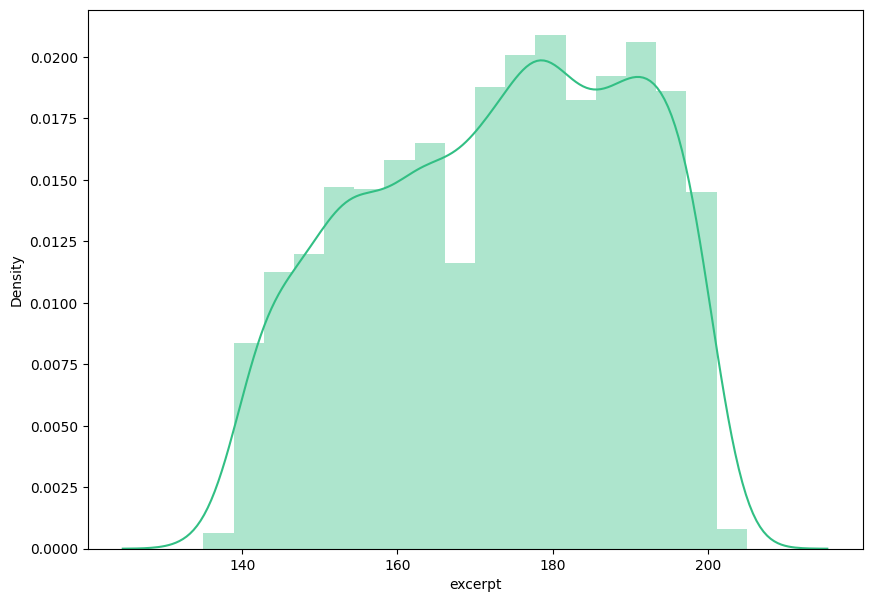

In [16]:
fig = plt.figure(figsize=[10,7])
sns.distplot(word_count, color=sns.xkcd_rgb['greenish teal'])
plt.show()

In [17]:
wc_test = dftest['excerpt'].apply(lambda x: len(x.split()))

In [18]:
wc_test

0    149
1    181
2    174
3    180
4    168
5    148
6    161
Name: excerpt, dtype: int64

In [19]:
word_count.max()

205

## Config

In [21]:
MODEL_OUT_DIR = './kaggle/model'
## Model Configurations
MAX_LEN_TRAIN = 205
MAX_LEN_VALID = 205
MAX_LEN_TEST = 205
BATCH_SIZE = 64
LR = 1e-3
NUM_EPOCHS = 10
NUM_THREADS = 1  ## Number of threads for collecting dataset
MODEL_NAME = 'bert-base-uncased'

if not os.path.isdir(MODEL_OUT_DIR):
    os.makedirs(MODEL_OUT_DIR)

## Scripts

In [23]:
class Excerpt_Dataset(Dataset):

    def __init__(self, data, maxlen, tokenizer): 
        #Store the contents of the file in a pandas dataframe
        self.df = data.reset_index()
        #Initialize the tokenizer for the desired transformer model
        self.tokenizer = tokenizer
        #Maximum length of the tokens list to keep all the sequences of fixed size
        self.maxlen = maxlen

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):    
        #Select the sentence and label at the specified index in the data frame
        excerpt = self.df.loc[index, 'excerpt']
        try:
            target = self.df.loc[index, 'target']
        except:
            target = 0.0
        identifier = self.df.loc[index, 'id']
        #Preprocess the text to be suitable for the transformer
        tokens = self.tokenizer.tokenize(excerpt) 
        tokens = ['[CLS]'] + tokens + ['[SEP]'] 
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))] 
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]'] 
        #Obtain the indices of the tokens in the BERT Vocabulary
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens) 
        input_ids = torch.tensor(input_ids) 
        #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attention_mask = (input_ids != 0).long()
        
        target = torch.tensor(target, dtype=torch.float32)
        
        return input_ids, attention_mask, target
        
print("Function 1 OK~")

Function 1 OK~


In [25]:
class BertRegresser(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)#find output
        #The output layer that takes the [CLS] representation and gives an output
        self.cls_layer1 = nn.Linear(config.hidden_size,128)
        self.relu1 = nn.ReLU()
        self.ff1 = nn.Linear(128,128)
        self.tanh1 = nn.Tanh()
        self.ff2 = nn.Linear(128,1)#2

    def forward(self, input_ids, attention_mask):
        #Feed the input to Bert model to obtain contextualized representations
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        #Obtain the representations of [CLS] heads
        logits = outputs.last_hidden_state[:,0,:]
        output = self.cls_layer1(logits)
        output = self.relu1(output)
        output = self.ff1(output)
        output = self.tanh1(output)
        output = self.ff2(output)
        return output

print("Function 2 OK~")

Function 2 OK~


## Train function

In [27]:
def evaluate(model, criterion, dataloader, device):
    model.eval()
    mean_acc, mean_loss, count = 0, 0, 0

    with torch.no_grad():
        for input_ids, attention_mask, target in (dataloader):
            
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
            output = model(input_ids, attention_mask)
            
            mean_loss += criterion(output, target.type_as(output)).item()
#             mean_err += get_rmse(output, target)
            count += 1
            
    return mean_loss/count

print("Function 3 OK~")

Function 3 OK~


In [32]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    best_acc = 0
    for epoch in trange(epochs, desc="Epoch"):
        model.train()
        train_loss = 0
        for i, (input_ids, attention_mask, target) in enumerate(iterable=train_loader):
            optimizer.zero_grad()  
            
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
            
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            
            loss = criterion(output, target.type_as(output))
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        print(f"Training loss is {train_loss/len(train_loader)}")
        val_loss = evaluate(model=model, criterion=criterion, dataloader=val_loader, device=device)
        print("Epoch {} complete! Validation Loss : {}".format(epoch, val_loss))
    
print("Function 4 OK~")

Function 4 OK~


## Evaluation function

In [34]:
def get_rmse(output, target):
    err = torch.sqrt(metrics.mean_squared_error(target, output))
    return err
print("Function 5 OK~")

Function 5 OK~


## Predict function

In [ ]:
def predict(model, dataloader, device):
    predicted_label = []
    actual_label = []
    with torch.no_grad():
        for input_ids, attention_mask, target in (dataloader):
            
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
            output = model(input_ids, attention_mask)
                        
            predicted_label += output
            actual_label += target
            
    return predicted_label
print("Function 6 OK~")

## Config

In [ ]:
## Configuration loaded from AutoConfig 
config = AutoConfig.from_pretrained(MODEL_NAME)
## Tokenizer loaded from AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
## Creating the model from the desired transformer model
model = BertRegresser.from_pretrained(MODEL_NAME, config=config)
## GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
## Putting model to device
model = model.to(device)
## Takes as the input the logits of the positive class and computes the binary cross-entropy 
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss()
## Optimizer
optimizer = optim.Adam(params=model.parameters(), lr=LR)

## Prep data

In [ ]:
## Training Dataset
train_set = Excerpt_Dataset(data=train_data, maxlen=MAX_LEN_TRAIN, tokenizer=tokenizer)
valid_set = Excerpt_Dataset(data=validation, maxlen=MAX_LEN_VALID, tokenizer=tokenizer)
test_set = Excerpt_Dataset(data=dftest, maxlen=MAX_LEN_TEST, tokenizer=tokenizer)


## Data Loaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, num_workers=NUM_THREADS)
valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, num_workers=NUM_THREADS)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, num_workers=NUM_THREADS)

# print(len(train_loader))

## Train

In [ ]:
train(model=model, 
      criterion=criterion,
      optimizer=optimizer, 
      train_loader=train_loader,
      val_loader=valid_loader,
      epochs = 10,
     device = device)

## Prediction

In [ ]:
output = predict(model, test_loader, device)

In [ ]:
output[0].shape

In [ ]:
output[0]

In [ ]:
out2 = []

In [ ]:
for out in output:
    out2.append(out.cpu().detach().numpy())

In [ ]:
out = np.array(out2).reshape(len(out2))

In [ ]:
submission = pd.DataFrame({'id': dftest['id'], 'target':out})

In [ ]:
submission.to_csv('submission.csv', index=False)